In [2]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pytorchtools import EarlyStopping
import math
from tqdm import tqdm

#### CUDA 사용 및 EarlyStopping 설정

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
early_stopping = EarlyStopping(patience = 5, verbose = True)

cpu


맥북 M2 MAX는 NVIDEA GPU를 사용하지 않아 CUDA 지원 안 함

#### 모델 저장

In [5]:
def saveModel():
    torch.save(model.state_dict(), f'../model_b_arma11_l24_v5.pt') # 모델의 학습된 매개변수 파일에 저장

#### 하이퍼 파라미터 설정

In [7]:
# 하이퍼파라미터 설정
length = 24            # 윈도우 사이즈 (생성할 시계열 데이터의 길이)
hidden_size1 = 48      # 은닉층 1 크기
hidden_size2 = 24      # 은닉층 2 크기
hidden_size3 = 12      # 은닉층 3 크기
hidden_size4 = 6       # 은닉층 4 크기
learning_rate = 1e-6   # 학습률
epoch = 400
trainrun = 50          # 생성할 학습 데이터 시퀀스의 수 
testrun = 25           # 생성할 평가 데이터 시퀀스의 수 
validrun = 25          # 생성할 검증 데이터 시퀀스의 수 

# 시계열 데이터 생성을 위한 매개변수
# 자기상관계수 (phi값을 0.2, 0.2, 0.4, 0.8, 0.8별로 생성)
phi1 = np.array([np.repeat(0.2,8),
                 np.repeat(0.2,8),
                 np.repeat(0.4,8),
                 np.repeat(0.8,8),
                 np.repeat(0.8,8)])
phi1 = np.concatenate(phi1)

# theta 값을 -0.2, -0.8, -0.4, -0.2, -0.8별로 생성
theta = np.array([np.repeat(-0.2,8),
                 np.repeat(-0.8,8),
                 np.repeat(-0.4,8),
                 np.repeat(-0.2,8),
                 np.repeat(-0.8,8)])
theta = np.concatenate(theta)

# 변화율 크기 (= 이상상태 포함 정도, psi) * 논문과 수치가 약간 변동이 있음
psi1 = np.array([0, 10, 15, 20, 23, 14, 17, 23,
                 0, 10, 15, 20, 23, 14, 17, 23,
                 0, 10, 15, 20, 23, 14, 17, 23,
                 0, 10, 15, 20, 23, 14, 17, 23,
                 0, 10, 15, 20, 23, 14, 17, 23,])

# 공정의 수준 변화율 (delta)
de1 = np.array([0, 0.5, 1, 2, 3, 0, 0, 0,
                0, 0.5, 1, 2, 3, 0, 0, 0,
                0, 0.5, 1, 2, 3, 0, 0, 0,
                0, 0.5, 1, 2, 3, 0, 0, 0,
                0, 0.5, 1, 2, 3, 0, 0, 0,])

# 공정의 분산 변화율 (gamma)
ga = np.array([1, 1, 1, 1, 1, 1.5, 2, 3,
               1, 1, 1, 1, 1, 1.5, 2, 3,
               1, 1, 1, 1, 1, 1.5, 2, 3,
               1, 1, 1, 1, 1, 1.5, 2, 3,
               1, 1, 1, 1, 1, 1.5, 2, 3,])

#### 시계열 데이터 생성

In [9]:
np.random.seed(1)

# AR(1) 시계열 데이터 생성 함수
def arma(phi1, theta, delta, gamma, psi, length, run):
    # 초기 설정
    y = np.zeros(shape=(run, length))                           # 생성될 시계열 데이터를 저장할 빈 배열을 초기화. 배열의 크기는 (생성할 데이터 시퀀스의 수, 각 시퀀스의 길이) 
    sigma = math.sqrt((1 + 2 * phi1 * theta + pow(theta, 2)) / (1 - pow(phi1, 2)))                    # AR(1)모델의 표준 편차
    
    # 데이터 시퀀스 생성
    for j in range(0, run):                                     # 각 run 마다 랜덤 노이즈(e)를 정규분포에서 추출하여 시계열의 기본 노이즈 생성 (과적합 방지 차원)
        e = np.random.normal(loc=0, scale=1, size=length)       
        x = np.array(np.repeat(0, length), dtype=np.float64)
        
        x[0] = e[0]                                             # x 배열 초기화하고, 첫 번째 시점의 값은 첫 번째 노이즈 값으로 설정 (시계열의 시작점에서 발생할 수 있는 임의성 반영 및 자기상관 구조 구현)

        # psi 시점 이전의 데이터 생성
        for i in range(1, psi):                                 # psi 시점 이전까지는 관리상태 데이터
            x[i] = phi1 * x[i - 1] + e[i] - theta * e[i-1]      # 각 시점에서의 값은 이전 시점의 값에 자기상관 계수 ar1을 곱한 것과 현재 시점의 노이즈를 더한 값으로 설정
            
        # psi 시점 이후의 데이터 생성 및 변동성 적용
        for i in range(psi,len(x)):                             # psi 시점 이후에는 각 에러 항에 gamma 값을 곱하여 에러 항의 변동성을 조절 
            e[i] = gamma * e[i]
            x[i] = phi1 * x[i-1] + e[i] - theta * e[i-1]
        for i in range(psi,len(x)):                             # delta(변동성 크기 조절하는 매개변수)를 통한 추가 변동성 적용
            x[i] = x[i] + delta*sigma
        
        # 최종 데이터 반환 (각 run에 대해 생성된 시계열 데이터를 저장)  
        y[j] = x

    return y


# 다양한 매개변수 조합에 대한 시계열 데이터 세트 생성
def totaldat(run,length):
    # 빈 데이터 배열 초기화
    y = np.zeros(shape=(len(phi1), run, length))
    # 매개변수 조합별 데이터 생성
    for i in range(len(phi1)):
        y[i]= arma(phi1[i], theta[i], de1[i], ga[i], psi1[i], length, run)

    return y


# 훈련용 시계열 데이터
# 데이터 생성 및 변형
train_x = totaldat(trainrun,length)                             # 훈련용 시계열 데이터 생성
train_x = train_x.reshape(trainrun*len(phi1),length)            # 생성된 훈련용 데이터를 적절한 형태로 재배열

# 레이블 생성 및 변형
train_y =  [np.repeat(0,trainrun),np.repeat(1,trainrun*7),      # 관리상태(1가지)는 0, 이상상태(7가지)는 1로 가정
            np.repeat(0,trainrun),np.repeat(1,trainrun*7),
            np.repeat(0,trainrun),np.repeat(1,trainrun*7),
            np.repeat(0,trainrun),np.repeat(1,trainrun*7),
            np.repeat(0,trainrun),np.repeat(1,trainrun*7),]
train_y =  np.concatenate(train_y)
train_y = train_y.reshape(2000,1)                               # 최종 레이블 배열의 형태를 조정 (학습용 데이터 세트 2000개)

# PyTorch 텐서로 변환 및 장치 할당
# train_x = torch.FloatTensor(train_x).to(device)
# train_y = torch.FloatTensor(train_y).to(device)


# 평가용 시계열 데이터
# 데이터 생성 및 변형
test_x = totaldat(run = testrun, length = length)
test_x = test_x.reshape(testrun*len(phi1),length)

# 레이블 생성 및 변형
test_y = [np.repeat(0,testrun),np.repeat(1,testrun*7),
          np.repeat(0,testrun),np.repeat(1,testrun*7),
          np.repeat(0,testrun),np.repeat(1,testrun*7),
          np.repeat(0,testrun),np.repeat(1,testrun*7),
          np.repeat(0,testrun),np.repeat(1,testrun*7),]
test_y = np.concatenate(test_y)
test_y = test_y.reshape(1000,1)                                 # 최종 레이블 배열의 형태를 조정 (평가용 데이터 세트 1000개)

# PyTorch 텐서로 변환 및 장치 할당
# test_x = torch.FloatTensor(test_x).to(device)
# test_y = torch.FloatTensor(test_y).to(device)


# 검증용 시계열 데이터
# 데이터 생성 및 변형
valid_x = totaldat(run = validrun, length = length)
valid_x = valid_x.reshape(validrun*len(phi1),length)

# 레이블 생성 및 변형
valid_y = [np.repeat(0,validrun),np.repeat(1,validrun*7),
            np.repeat(0,validrun),np.repeat(1,validrun*7),
            np.repeat(0,validrun),np.repeat(1,validrun*7),
            np.repeat(0,validrun),np.repeat(1,validrun*7),
            np.repeat(0,validrun),np.repeat(1,validrun*7),]
valid_y = np.concatenate(valid_y)
valid_y = valid_y.reshape(1000,1)                                 # 최종 레이블 배열의 형태를 조정 (검증용 데이터 세트 1000개)


# PyTorch 텐서로 변환 및 장치 할당
train_x = torch.FloatTensor(train_x).to(device)
train_y = torch.FloatTensor(train_y).to(device)
test_x = torch.FloatTensor(test_x).to(device)
test_y = torch.FloatTensor(test_y).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)
valid_y = torch.FloatTensor(valid_y).to(device)

# DataLoader 설정
trainset = TensorDataset(train_x, train_y)                        # 데이터와 레이블 쌍을 포함하는 데이터셋 생성
trainloader = DataLoader(trainset, shuffle=True)                  # 데이터셋에서 미니배치 자동으로 생성 후 모델 학습 및 평가 시 배치 처리를 용이하게 함 (훈련에서는 데이터를 섞어 학습 과정에서의 일반화 능력 향상)
testset = TensorDataset(test_x, test_y)
testloader = DataLoader(testset,shuffle = False)                  # 학습 및 검증에서는 데이터 순서 유지
validset = TensorDataset(valid_x, valid_y)
validloader = DataLoader(validset,shuffle = False)

#### 모델 구조

In [10]:
class NeuralNetwork(nn.Module):
    # 클래스 초기화
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(NeuralNetwork, self).__init__()
        self.device = device                                          
        self.hidden_size = hidden_size                                # RNN 모델의 은닉층 크기 
        self.num_layers = num_layers                                  # RNN 모델의 층 개수
        
        # 기본 RNN 레이어 생성
        self.rnn = nn.RNN(input_size= input_size,
                          hidden_size = hidden_size1,
                          num_layers = num_layers,
                          nonlinearity= "relu",                       # 활성화 함수로 relu를 사용
                          batch_first= True)                          # 입력 텐서의 첫 번째 차원이 배치 크기임을 나타냄
        
        # 완전 연결 레이어 (여러 레이어를 연속적으로 적용할 수 있게 하기 위해 nn.Sequential을 사용)
        self.fc = nn.Sequential(nn.Linear(hidden_size,hidden_size2),  # 선형 레이어
                                nn.GELU(),                            # GELU 활성화 함수
                                nn.Linear(hidden_size2,hidden_size3),
                                nn.GELU(),
                                nn.Linear(hidden_size3,hidden_size4),
                                nn.GELU(),
                                nn.Linear(hidden_size4,1),
                                nn.Sigmoid()                          # 시그모이드 활성화함수를 사용해 출력을 [0, 1] 범위로 조정
                                )

    # 순전파 (forward)
    def forward(self, x):
        # 초기 hidden state 설정
        h0 = torch.zeros(x.size()[0], self.hidden_size).to(device)    # 각 배치에 대한 초기 은닉층을 0으로 설정 (= RNN의 첫 번째 시점에서 이전 상태가 없음을 의미)
        
        # RNN 레이어 실행
        out, _ = self.rnn(x, h0)                                      # 입력 데이터 x와 초기 은닉층 h0를 RNN 층에 전달함. out: RNN의 마지막 레이어로부터 나온 output feature 를 반환 (hn: hidden state를 반환)
        
        # 데이터 재구성 및 완전 연결 레이어 실행
        out = out.reshape(out.shape[0], -1)                           # many to many 전략 : 시퀀스의 각 타임 스텝에 대응하는 출력 생성 
        out = self.fc(out)                                            # out을 재구성하여 모든 시간 단계의 출력을 하나의 벡터로 평탄화하고 완전 연결 레이어를 통해 최종 예측값을 계산
        
        return out


# 모델 초기화
model = NeuralNetwork(input_size = length, hidden_size = hidden_size1, num_layers = 1, device = device).to(device)

# Optimizer 설정
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# 손실 함수 설정
criterion = nn.MSELoss()

# 손실 기록을 위한 리스트 초기화
loss_ = []                                                            # 훈련 과정에서의 손실값 기록
n = len(trainloader)
valoss_ = []                                                          # 검증 과정에서의 손실값 기록
logger = {"train_loss": list(),
          "validation_loss": list()
         }

#### 학습 (Training)

epoch 1
train loss : 0.22502085939794778, validation loss : 0.22458135436475277
Validation loss decreased (inf --> 0.224581).  Saving model ...
epoch 2
train loss : 0.22455048925802112, validation loss : 0.22411351966857912
Validation loss decreased (0.224581 --> 0.224114).  Saving model ...
epoch 3
train loss : 0.22408226210375629, validation loss : 0.22364683355391027
Validation loss decreased (0.224114 --> 0.223647).  Saving model ...
epoch 4
train loss : 0.22361620122566822, validation loss : 0.22318125458434226
Validation loss decreased (0.223647 --> 0.223181).  Saving model ...
epoch 5
train loss : 0.22315113574415446, validation loss : 0.22271648085415366
Validation loss decreased (0.223181 --> 0.222716).  Saving model ...
epoch 6
train loss : 0.22268632160375515, validation loss : 0.22225176403423152
Validation loss decreased (0.222716 --> 0.222252).  Saving model ...
epoch 7
train loss : 0.22222126597166061, validation loss : 0.2217865736995425
Validation loss decreased (0.222

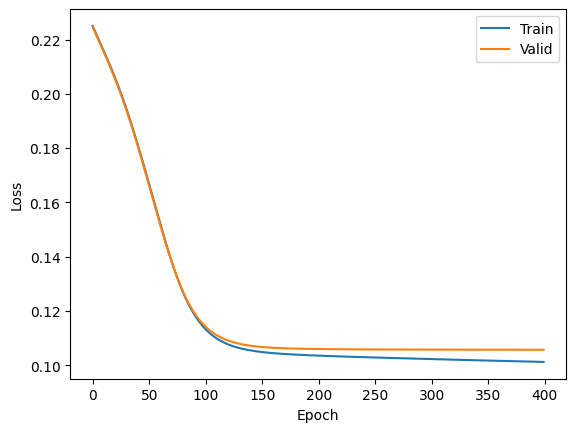

In [11]:
def training(epochs) :
    # epoch 별 훈련 및 검증 루프 (trainloader를 반복하여 모델 훈련시키고, validloader를 사용해 모델의 성능 검증)
    for epoch in range(epochs):
        running_train_loss = 0.0
        running_vall_loss = 0.0
        total = 0

        # 훈련 과정
        for data in trainloader:
            model.train()
            inputs, outputs = data
            optimizer.zero_grad()                                                     # Optimizer Gradient를 0으로 초기화. 이는 각 미니배치마다 Gradient가 누적되는 것을 방지
            predicted_outputs = model(inputs)                                         # 모델을 사용하여 입력 데이터에 대한 예측값을 계산
            train_loss = criterion(predicted_outputs, outputs)                        # 계산된 예측값과 실제 레이블 간의 손실을 계산
            train_loss.backward()                                                     # 손실에 대한 역전파를 수행하여 Gradient를 계산
            optimizer.step()                                                          # 계산된 Gradient를 사용하여 모델 매개변수를 업데이트
            running_train_loss += train_loss.item()                                   # track the loss value
        loss_.append(running_train_loss / n)
        
        # 검증 과정
        with torch.no_grad():                                                         # Gradient 계산을 비활성화하여 메모리 사용량을 줄이고 계산 속도를 향상 
            model.eval()
            for data in validloader:
                inputs, outputs = data
                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, outputs)

                # The label with the highest value will be our prediction
                _, predicted = torch.max(predicted_outputs,1)
                running_vall_loss += val_loss.item()
                total += outputs.size(0)
                val_loss_value = running_vall_loss/len(validloader)
        valoss_.append(val_loss_value)

        avgtrainloss = np.mean(loss_)
        avgvalidloss = np.mean(valoss_)
        print('epoch', epoch + 1)
        print(f'train loss : {avgtrainloss}, validation loss : {avgvalidloss}')
        
        # EarlyStopping
        early_stopping(avgvalidloss, model)                                           # 검증 손실을 기준으로 조기 종료 조건 확인
        if early_stopping.early_stop:                                                 # 조건 만족 시 조기 종료
            break

    # 모델 저장    
    saveModel()
training(epochs = epoch)


# 손실 시각화
plt.plot(loss_)
plt.plot(valoss_)
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### 평가 (Evaluation)

In [12]:
def evaluation(dataloader):
  # 초기화
  predictions = torch.tensor([], dtype=torch.float64,device = device)  # 예측값을 저장하는 텐서.
  actual = torch.tensor([], dtype=torch.float64, device = device)      # 실제값을 저장하는 텐서.

  # 평가 모드 설정
  with torch.no_grad():
    model.eval()                                                       # 평가를 할 땐 반드시 eval()을 사용해야 한다.

    # 데이터 로더를 통한 반복
    for data in dataloader:
        inputs, values = data
        outputs = model(inputs)

        # 예측값 및 실제값 저장
        predictions = torch.cat((predictions, outputs), 0)             # cat함수를 통해 예측값을 누적.
        actual = torch.cat((actual, values), 0)                        # cat함수를 통해 실제값을 누적.
  
  # CPU로 이동 및 NumPy 배열 변환
  predictions =predictions.to(device= "cpu")
  predictions = predictions.numpy()                                    # 넘파이 배열로 변경.
  actual = actual.to(device= "cpu")
  actual = actual.numpy()                                              # 넘파이 배열로 변경.
  
  # RMSE 계산
  rmse = np.sqrt(mean_squared_error(predictions, actual))              # sklearn을 이용해 RMSE를 계산.

  return rmse,actual,predictions

preds = []
for i in tqdm(range(10000)):
  test_rmse, actual, pred = evaluation(testloader)
  preds.append(pred)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [11:38<00:00, 14.31it/s]


In [13]:
test_rmse

0.32525758359538454

In [14]:
actual

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [15]:
pred

array([[0.82925373],
       [0.83910036],
       [0.7884391 ],
       [0.70573872],
       [0.82391906],
       [0.74098319],
       [0.79373807],
       [0.74696046],
       [0.81288618],
       [0.7619018 ],
       [0.81172562],
       [0.76455021],
       [0.71813208],
       [0.74045193],
       [0.77286613],
       [0.79626834],
       [0.82769257],
       [0.88206357],
       [0.83242273],
       [0.82615221],
       [0.83104068],
       [0.76846093],
       [0.87365264],
       [0.81655878],
       [0.77760267],
       [0.82767165],
       [0.85653996],
       [0.82179374],
       [0.88621706],
       [0.82844895],
       [0.78240329],
       [0.84869975],
       [0.82157689],
       [0.91277552],
       [0.79256135],
       [0.73622233],
       [0.91947788],
       [0.83733875],
       [0.86554122],
       [0.88660473],
       [0.86042863],
       [0.78751326],
       [0.85895479],
       [0.86732823],
       [0.86074179],
       [0.88200617],
       [0.77711987],
       [0.930

In [16]:
pred.shape

(1000, 1)

#### 실제값과 예측값 시각화

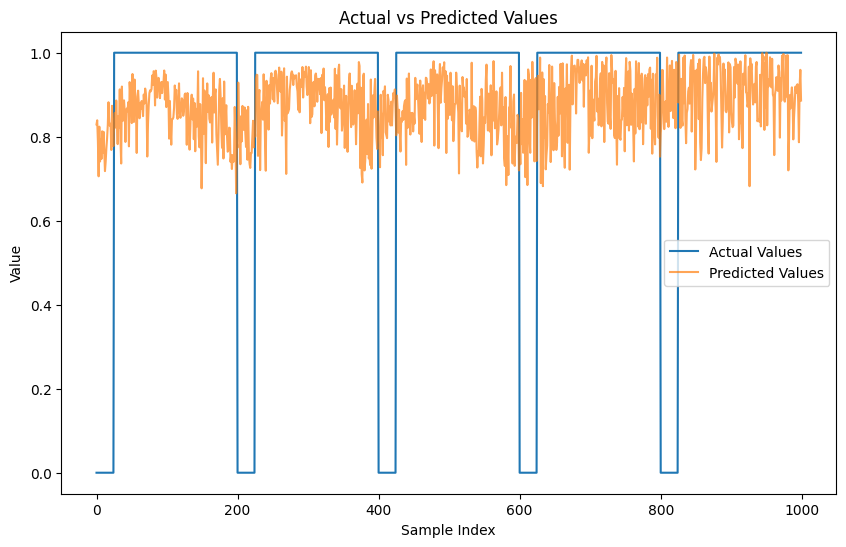

In [17]:
# 실제 값과 예측값을 시각화하는 코드
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(actual, label='Actual Values')  # 실제 값 그래프
plt.plot(pred, label='Predicted Values', alpha=0.7)  # 예측 값 그래프, 투명도를 주어 구분하기 쉽게 함
plt.title('Actual vs Predicted Values')  # 그래프 제목
plt.xlabel('Sample Index')  # x축 라벨
plt.ylabel('Value')  # y축 라벨
plt.legend()  # 범례 표시
plt.show()  # 그래프 표시

#### ARL0 구하기

In [25]:
np.random.seed(1)

l = 24

# 관리상태 / 이상상태 데이터 생성 함수
def armagen(phi1, theta, psi, delta, gamma, length) :

    e = np.random.normal(loc=0, scale = 1,size = length)
    sigma = math.sqrt((1 + 2 * phi1 * theta + pow(theta, 2)) / (1 - pow(phi1, 2))) 
    x = np.array(np.repeat(0, length), dtype= np.float64)
    x[0] = e[0]
    z = np.array(np.repeat(0, length), dtype=np.float64)

    for i in range(1, psi):
        x[i] = phi1 * x[i-1] + e[i] - theta * e[i-1]
        z[i] = x[i]
    for i in range(psi,len(x)):
        x[i] = phi1 * x[i-1] + gamma * e[i] - theta * e[i-1]
        z[i] = x[i]
    for i in range(psi,len(z)):
        z[i] = z[i] + delta * sigma

    return z

In [79]:
def arl(phi1, theta, delta,gamma, run, length,cl) :
    rl = np.array([], dtype=np.float64)

    for i in tqdm(range(run)) :
        y = armagen(phi1=phi1, theta = theta, psi=l-1, delta=delta, gamma = gamma,length=length)
        a = np.array([length-l])
        x = np.zeros(shape=(length-l, l)) # empty 대신 zeros
        for j in range(length-l):
            x[j] = y[j: j + l]
            
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]      # shape 형태

                output = model(input)

                if output[0] > cl :
                    a = np.array([j + 1])
                    break
                elif j == len(x):
                    a = len(x)

            rl = np.append(rl,a)

    arl = np.mean(rl)
    return arl

In [73]:
arl(phi1 = 0.2, theta = -0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.94)

100%|██████████| 1000/1000 [00:41<00:00, 24.07it/s]


790.828

In [75]:
arl(phi1 = 0.2, theta = -0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.94)

100%|██████████| 1000/1000 [00:55<00:00, 18.13it/s]


770.526

In [4]:
np.zeros(shape=(10, 1))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

#### ARL1 구하기

In [27]:
def arl1(phi1, theta, run,length,cl):
    a5 = arl(phi1, theta, 0.5, 1, run, length, cl)
    a1 = arl(phi1, theta, 1, 1, run, length, cl)
    a2 = arl(phi1, theta, 2, 1, run, length, cl)
    a3 = arl(phi1, theta, 3, 1, run, length, cl)
    b5 = arl(phi1, theta, 0.5, 1.5,run, length, cl)
    b1 = arl(phi1, theta, 1, 1.5, run, length, cl)
    b2 = arl(phi1, theta, 2, 1.5, run, length, cl)
    b3 = arl(phi1, theta, 3, 1, run, length, cl)
    c1 = arl(phi1, theta, 0, 1.5, run, length, cl)
    c2 = arl(phi1, theta, 0, 2, run, length, cl)
    c3 = arl(phi1, theta, 0, 3, run, length, cl)
    print(f'0.5: {a5}, 1:{a1},2:{a2},3:{a3}')
    print(f'0.5:{b5},1:{b1},2:{b2},3:{b3}')
    print(f'1.5:{c1},2:{c2},3:{c3}')

### phi = 0.2, theta = -0.2 일 때

#### ARL0 (threshold 임의 추정)

In [24]:
arl(phi1 = 0.2, theta = -0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.94)

100%|██████████| 10000/10000 [07:29<00:00, 22.26it/s]


782.7461

In [28]:
arl(phi1 = 0.2, theta = -0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.92)

100%|██████████| 10000/10000 [02:32<00:00, 65.42it/s]


257.3008

In [29]:
arl(phi1 = 0.2, theta = -0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.93)

100%|██████████| 10000/10000 [04:53<00:00, 34.03it/s]


506.347

In [31]:
arl(phi1 = 0.2, theta = -0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.925)

100%|██████████| 10000/10000 [03:32<00:00, 47.17it/s]


364.5542

In [32]:
arl(phi1 = 0.2, theta = -0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.926)

100%|██████████| 10000/10000 [03:48<00:00, 43.76it/s]


394.3494

In [34]:
arl(phi1 = 0.2, theta = -0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9255)

100%|██████████| 10000/10000 [03:35<00:00, 46.33it/s]


374.2658

In [35]:
arl(phi1 = 0.2, theta = -0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9253)

100%|██████████| 10000/10000 [03:33<00:00, 46.79it/s]


369.8483

In [36]:
arl(phi1 = 0.2, theta = -0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.92535)

100%|██████████| 10000/10000 [03:34<00:00, 46.72it/s]


374.2256

#### ARL1

In [37]:
arl1(phi1=0.2, theta = -0.2, run=10000, length=1000, cl=0.9253)

100%|██████████| 10000/10000 [00:14<00:00, 701.57it/s]

0.5: 51.3561, 1:15.6918,2:5.4799,3:3.1322
0.5:22.3631,1:11.7541,2:5.2671,3:3.1381
1.5:57.0259,2:25.3908,3:11.6309


### phi = 0.2, theta = -0.8 일 때

#### ARL0 (threshold 임의 추정)

In [38]:
arl(phi1 = 0.2, theta = -0.8, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.93)

100%|██████████| 10000/10000 [00:52<00:00, 188.85it/s]


81.3287

In [40]:
arl(phi1 = 0.2, theta = -0.8, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.95)

100%|██████████| 10000/10000 [02:56<00:00, 56.76it/s]


302.3867

In [41]:
arl(phi1 = 0.2, theta = -0.8, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.96)

100%|██████████| 10000/10000 [05:48<00:00, 28.66it/s]


611.2836

In [42]:
arl(phi1 = 0.2, theta = -0.8, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.954)

100%|██████████| 10000/10000 [03:56<00:00, 42.35it/s]


410.0827

In [43]:
arl(phi1 = 0.2, theta = -0.8, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.952)

100%|██████████| 10000/10000 [03:23<00:00, 49.03it/s]


354.3022

In [44]:
arl(phi1 = 0.2, theta = -0.8, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.953)

100%|██████████| 10000/10000 [03:43<00:00, 44.66it/s]


391.0003

In [45]:
arl(phi1 = 0.2, theta = -0.8, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9525)

100%|██████████| 10000/10000 [03:33<00:00, 46.92it/s]


371.4289

#### ARL1

In [46]:
arl1(phi1=0.2, theta = -0.8, run=10000, length=1000, cl=0.9525)

100%|██████████| 10000/10000 [00:18<00:00, 543.46it/s]

0.5: 70.8224, 1:22.9899,2:7.5159,3:4.1006
0.5:35.5315,1:17.1962,2:7.085,3:4.0877
1.5:95.2733,2:43.636,3:18.9859


### phi = 0.4, theta = -0.4 일 때

#### ARL0 (threshold 임의 추정)

In [48]:
arl(phi1 = 0.4, theta = -0.4, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.95)

100%|██████████| 10000/10000 [03:29<00:00, 47.69it/s]


360.33

In [49]:
arl(phi1 = 0.4, theta = -0.4, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.955)

100%|██████████| 10000/10000 [04:50<00:00, 34.46it/s]


509.5376

In [50]:
arl(phi1 = 0.4, theta = -0.4, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.952)

100%|██████████| 10000/10000 [04:02<00:00, 41.21it/s]


423.701

In [51]:
arl(phi1 = 0.4, theta = -0.4, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.951)

100%|██████████| 10000/10000 [03:42<00:00, 44.97it/s]


387.3558

In [57]:
arl(phi1 = 0.4, theta = -0.4, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9505)

100%|██████████| 10000/10000 [03:33<00:00, 46.84it/s]


371.8089

In [53]:
arl(phi1 = 0.4, theta = -0.4, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9502)

100%|██████████| 10000/10000 [03:32<00:00, 47.10it/s]


368.6519

In [54]:
arl(phi1 = 0.4, theta = -0.4, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.9503)

100%|██████████| 10000/10000 [03:34<00:00, 46.57it/s]


373.423

In [55]:
arl(phi1 = 0.4, theta = -0.4, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.95025)

100%|██████████| 10000/10000 [03:33<00:00, 46.91it/s]


370.7984

#### ARL1

In [56]:
arl1(phi1=0.4, theta = -0.4, run=10000, length=1000, cl=0.95025)

100%|██████████| 10000/10000 [00:17<00:00, 571.41it/s]

0.5: 88.3139, 1:31.0203,2:9.7291,3:5.0722
0.5:35.8561,1:20.3327,2:8.9624,3:5.1784
1.5:79.5719,2:37.1351,3:17.1032


### phi = 0.8, theta = -0.2 일 때

#### ARL0 (threshold 임의 추정)

In [58]:
arl(phi1 = 0.8, theta = -0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.988495)

100%|██████████| 10000/10000 [05:29<00:00, 30.39it/s]


581.7198

#### ARL1

In [59]:
arl1(phi1=0.8, theta = -0.2, run=10000, length=1000, cl=0.988495)

100%|██████████| 10000/10000 [00:28<00:00, 351.48it/s]

0.5: 259.6065, 1:103.2527,2:26.3821,3:11.374
0.5:84.5914,1:50.9058,2:21.801,3:11.3911
1.5:154.1462,2:76.2075,3:37.2409


### phi = 0.8, theta = -0.8 일 때

#### ARL0 (threshold 임의 추정)

In [60]:
arl(phi1=0.8, theta = -0.8, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.997524)

100%|██████████| 10000/10000 [05:36<00:00, 29.74it/s]


610.5634

#### ARL1

In [61]:
arl1(phi1=0.8, theta = -0.8, run=10000, length=1000, cl=0.997524)

100%|██████████| 10000/10000 [00:38<00:00, 260.58it/s]

0.5: 439.01, 1:288.9004,2:120.926,3:57.3125
0.5:171.1143,1:123.6757,2:67.2496,3:57.0942
1.5:241.9267,2:119.7791,3:56.9063
